In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import debvader

### Deblend stamps randomly generated from DC2 data

Load 10 DC2 images centred on galaxy. They have been generated using this notebook: https://github.com/BastienArcelin/dc2_img_generation/blob/main/notebooks/dc2_stamps_and_corresponding_parameters.ipynb

In [2]:
path_folder = os.path.dirname(os.path.abspath("__file__"))
images = np.load(path_folder+'/../data/dc2_imgs/imgs_dc2.npy', mmap_mode = 'c')

Visualize some of the images

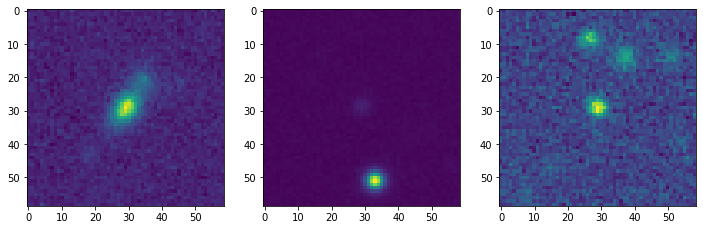

In [3]:
fig, axes = plt.subplots(1,3, figsize = (12, 4))
for i in range (3):
    axes[i].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)

Now we can load the deblender

In [4]:
# First, define the parameters of the neural network, for this version of debvader, they are as follow:
nb_of_bands = 6
input_shape = (59, 59, nb_of_bands)
latent_dim = 32
filters = [32,64,128,256]
kernels = [3,3,3,3]

# We will load the weights of the network trained on DC2 images
survey = "dc2"

In [9]:
# Load the network using the load_deblender function
net = debvader.debvader.load_deblender(survey, input_shape, latent_dim, filters, kernels)

in cropping
/sps/lsst/users/barcelin/miniconda/envs/myenv_test_debvader/lib/python3.6/site-packages/debvader
/sps/lsst/users/barcelin/miniconda/envs/myenv_test_debvader/lib/python3.6/site-packages/debvader/../data/weights/dc2/not_normalised/


In [10]:
# We can visualize the network
net.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 59, 59, 6)]       0         
_________________________________________________________________
model_3 (Model)              (None, 560)               3741224   
_________________________________________________________________
multivariate_normal_tri_l_1  ((None, 32), (None, 32))  0         
_________________________________________________________________
model_4 (Model)              (None, 59, 59, 6)         4577228   
Total params: 8,318,452
Trainable params: 3,741,212
Non-trainable params: 4,577,240
_________________________________________________________________


We now have everything to do the deblending. Let's use our network to deblend the DC2 images

In [11]:
output_images_mean, output_images_distribution = debvader.debvader.deblend(net, images)

Here the network outputs a distribution over the pixels for each pixel in each filter, this is why both the mean image and the corresponding distribution is outputed.

Let's first visualize the mean images outputed by debvader.

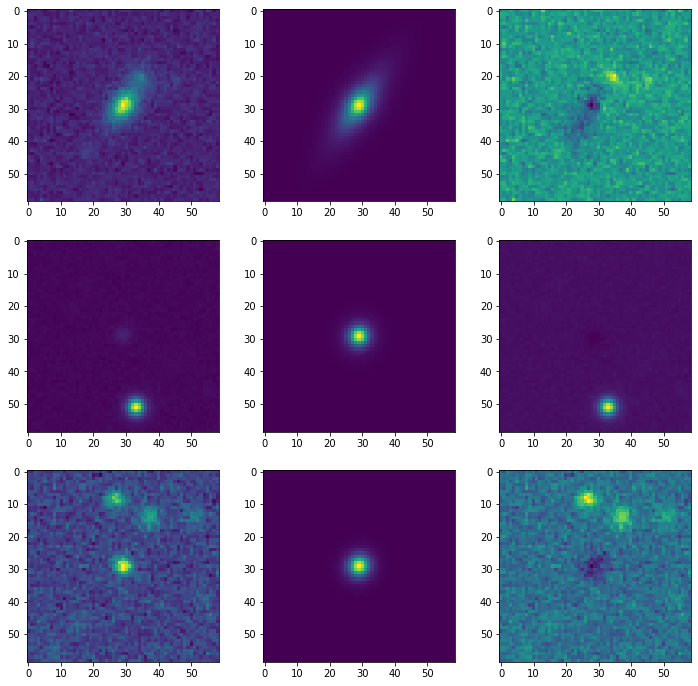

In [12]:
fig, axes = plt.subplots(3,3, figsize = (12, 12))
for i in range (3):
    axes[i,0].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)
    axes[i,1].imshow(output_images_mean[i,:,:,2]) # We plot only r-band here, but the output images are multi-bands (ugrizy)
    axes[i,2].imshow(images[i,:,:,2]-output_images_mean[i,:,:,2])

Now we can look at what the images of the standard deviation look like for each example, and how we can sample this distribution in each pixel.

In [13]:
output_uncertainty_mean = output_images_distribution.mean().numpy() # Extract the mean of the distribution. Same image as output_images_mean.
output_uncertainty_std = output_images_distribution.stddev().numpy() # Extract the standard deviation of the distribution.
output_uncertainty_sample = tf.math.reduce_mean(output_images_distribution.sample(100), axis = 0).numpy() # Sample 100 times the distribution in each pixel and produce a mean image.

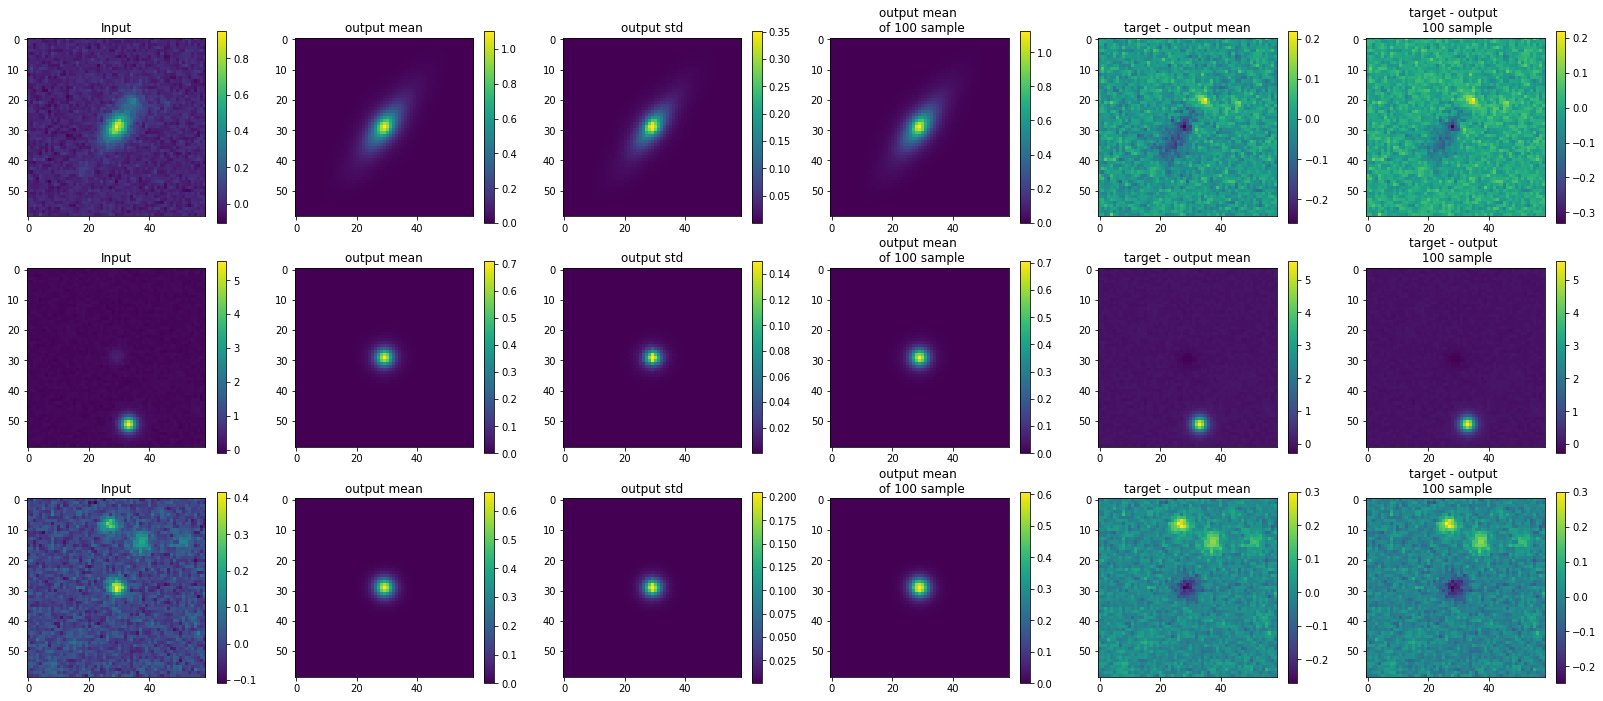

In [14]:
fig, axes = plt.subplots(3,6, figsize = (28, 12))

for i in range (3):
    f1 = axes[i,0].imshow(images[i,:,:,2])
    f2 = axes[i,1].imshow(output_uncertainty_mean[i,:,:,2])
    f3 = axes[i,2].imshow(output_uncertainty_std[i,:,:,2])
    f4 = axes[i,3].imshow(output_uncertainty_sample[i,:,:,2])
    f5 = axes[i,4].imshow(images[i,:,:,2] - output_uncertainty_mean[i,:,:,2])
    f6 = axes[i,5].imshow(images[i,:,:,2] - output_uncertainty_sample[i,:,:,2])
    fig.colorbar(f1, ax = axes[i,0])
    fig.colorbar(f2, ax = axes[i,1])
    fig.colorbar(f3, ax = axes[i,2])
    fig.colorbar(f4, ax = axes[i,3])
    fig.colorbar(f5, ax = axes[i,4])
    fig.colorbar(f6, ax = axes[i,5])

    axes[i,0].set_title('Input')
    axes[i,1].set_title('output mean')
    axes[i,2].set_title('output std')
    axes[i,3].set_title('output mean \n of 100 sample')
    axes[i,4].set_title('target - output mean')
    axes[i,5].set_title('target - output \n 100 sample')

### Deblend a DC2 field

Load DC2 field image and corresponding galaxy stamps. They have been generated using this notebook: https://github.com/BastienArcelin/dc2_img_generation/blob/main/notebooks/dc2_stamps_and_corresponding_parameters.ipynb

In [15]:
path_folder = os.path.dirname(os.path.abspath("__file__"))
field_img = np.load(path_folder+'/../data/dc2_imgs/field/field_img.npy', mmap_mode = 'c') # DC2 field image
cutout_galaxy_img = np.load(path_folder+'/../data/dc2_imgs/field/galaxies_from_field.npy', mmap_mode = 'c') # stamps from galaxies below a magnitude of 24.5 in the r-band
field_galaxies_coordinates = np.load(path_folder+'/../data/dc2_imgs/field/ra_dec_coord.npy', allow_pickle=True) # Coordinates of the field and the different stamps (in pixels)

Set some parameters:

In [16]:
cutout_size = 59 # pixels
field_size = 259 # pixels
nb_of_bands = 6 # six LSST filters

Retrieve coordinates in pixels from the DC2 simulation of the field center and of each galaxy detected (with a magnitude cut at 24.5 in the $r$-band).

In [17]:
field_center = field_galaxies_coordinates[0]
galaxies_coord = field_galaxies_coordinates[1]

Compute distances (in pixels) of galaxies from the center of the field:

In [18]:
field_coordinates = np.array(field_galaxies_coordinates[0])
galaxies_coordinates = np.array(field_galaxies_coordinates[1])

galaxy_distances_to_center = []
for i in range(len(galaxies_coordinates)):
    galaxy_distances_to_center.append((int(-field_center[1]+galaxies_coord[i][1]), int(-field_center[0]+galaxies_coord[i][0])))

galaxy_distances_to_center=np.array(galaxy_distances_to_center)

Feed the deblend_field with the required paramter, including the distances of the galaxies from the center of the field (it is also possible to directly include the cutouts. Here I show an example where we do not have the cutouts in advance):

In [20]:
field_img, deblended_field_img, denoised_field, cutout_images, output_images_mean = debvader.debvader.deblend_field(net, field_img, galaxy_distances_to_center)

The function outputs both the initial field and the field subtracted from the deblended galaxies. It also provide an image of the model proposed by the deblender for the denoised field.

Text(0.5, 1.0, 'Field composed of the deblended galaxies')

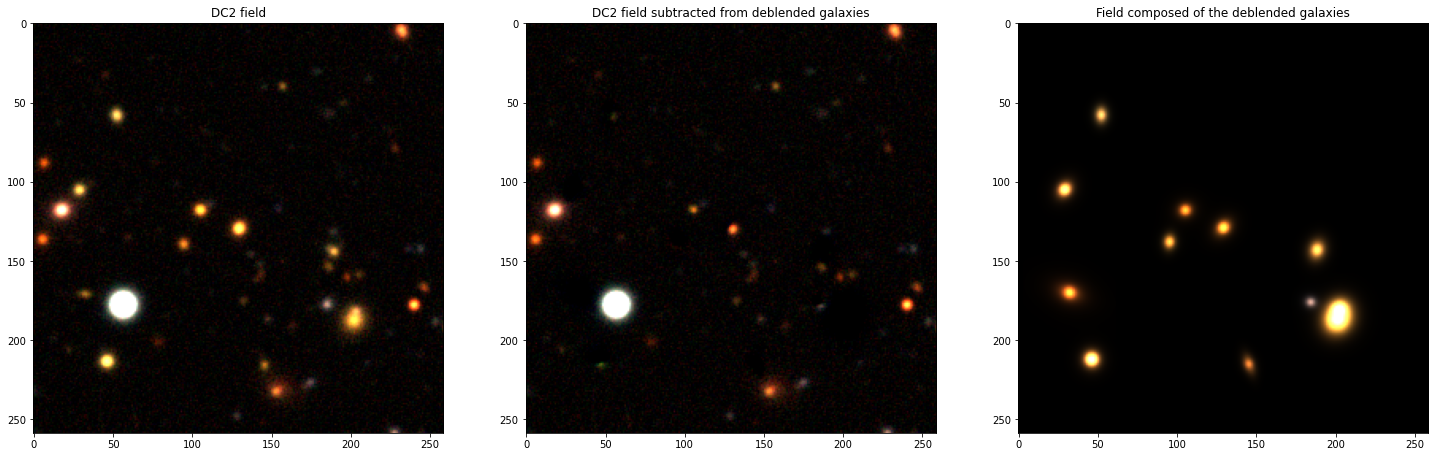

In [21]:
bands = [3,2,1]

fig, axes = plt.subplots(1,3, figsize = (25,15))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(denoised_field[:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')

It is also possible to access simply the different cutouts and the deblended galaxies from the cutouts. We plot only r-band here, but the output images are multi-bands (ugrizy)::

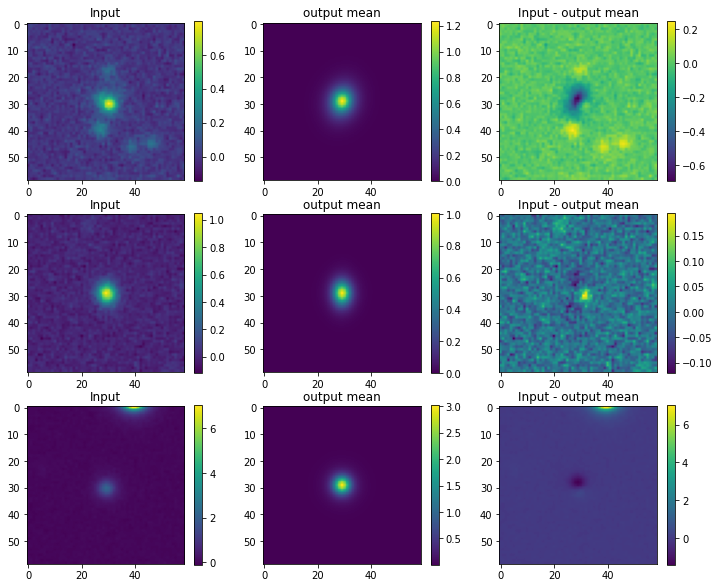

In [22]:
fig, axes = plt.subplots(3,3, figsize = (12, 10))
for i in range (3):
    f1 = axes[i,0].imshow(cutout_images[i,:,:,2])
    f2 = axes[i,1].imshow(output_images_mean[i,:,:,2])
    f3 = axes[i,2].imshow(cutout_images[i,:,:,2]-output_images_mean[i,:,:,2])
    
    fig.colorbar(f1, ax = axes[i,0])
    fig.colorbar(f2, ax = axes[i,1])
    fig.colorbar(f3, ax = axes[i,2])
    
    axes[i,0].set_title('Input')
    axes[i,1].set_title('output mean')
    axes[i,2].set_title('Input - output mean')

As a safety check it is possible to verify that the shifts used are correct and that we retrieve the target galaxies:

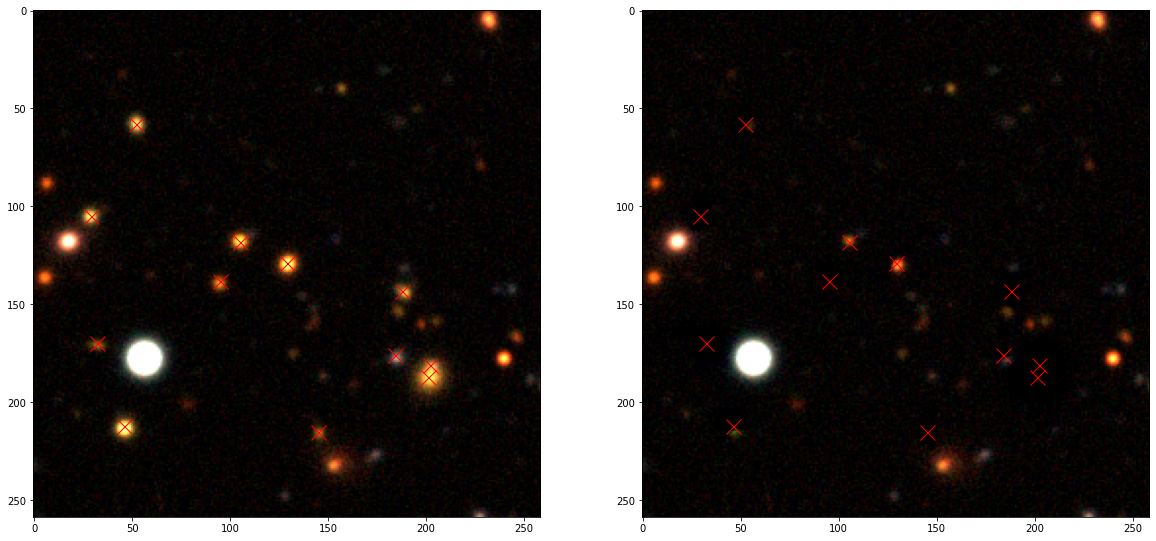

In [23]:
bands = [3,2,1]

fig, axes = plt.subplots(1,2, figsize = (20,10))
axes[0].imshow(np.clip(field_img[0][:,:,bands], a_min=0.0, a_max=1.))
for i in range(len(output_images_mean)):
    axes[0].plot(129+int((galaxy_distances_to_center[i][1])),129+int((galaxy_distances_to_center[i][0])), 'x', color = 'red', markersize = 15)
    axes[1].imshow(np.clip(deblended_field_img[0][:,:,bands], a_min=0.0, a_max=1.))
    axes[1].plot(129+int((galaxy_distances_to_center[i][1])),129+int((galaxy_distances_to_center[i][0])), 'x', color = 'red', markersize = 15)


There are still some residuals, the training must be improved !